# Compressible Boundary layer

## Equations

The compressible equations are given by:
$$
\begin{align}
 (Cf^{''})^{'} + ff^{''} &=0 \\
\left(\frac{C}{Pr}g_e^{'}\right)^{'} + fg_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 &=0
\end{align}
$$
With the boundary conditions:
$$f(0)=0,\quad f^{'}(0)=0,\quad g_e(0)=g_{e-w}$$
And the $Pr$ and $C$ given by:
$$
\begin{align}
Pr(g_e) &= \frac{\mu(g_e) c_p(g_e)} {k(g_e)} \\
C(g_e) &=\frac{\rho(g_e) \mu(g_e)}{\rho_e\rho_e} \\
\end{align}
$$

## Derivation ODE

Rewrite using product rule
\begin{align}
 Cf^{'''} + \left(C^{'}+ f\right)f^{''} &=0 \\
\frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + C\left(\frac{1}{Pr}\right)^{'} + f \right)g_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 &=0
\end{align}
Further rewritten
$$ \frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)g_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 =0 $$

Define the following variables:
$$
\begin{align}
g &= f^{'}  \\
h &= g^{'}  \\
t &= g_e^{'}
\end{align}
$$

Pluggin into original equations gives:

\begin{align}
Ch^{'} + \left(C^{'}+f\right) h &= 0 \\
f' &= g \\
g' &= h \\
\frac{C}{Pr}t^{'}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)t + C\frac{u_e}{h_e}\left(h\right)^2 &=0 \\
g_e^{'} &= t
\end{align}

with
\begin{align}
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}



This gives the following ODEs to be solved

\begin{align}
h^{'} &=- \frac{\left(C^{'}+f\right)}{C} h  \\
f' &= g \\
g' &= h \\
t^{'}  &=- \left(\frac{C^{'}}{C} + \frac{1}{Pr}{Pr}^{'} + \frac{fPr}{C} \right)t - Pr\frac{u_e}{h_e}\left(h\right)^2 \\
g_e^{'} &= t
\end{align}



With:
$$
\begin{align}
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}
$$

## Numerical Method

$$
\begin{align}
h(x+\Delta x) &= h(x) -\frac{C^{'}+f(x)}{C}h(x)\Delta x& \\
f(x+\Delta x) &= f(x) +g(x)\Delta x&      \\
g(x+\Delta x) &= g(x) +h(x)\Delta x&      \\
t(x+\Delta x) &= t(x) -\left(\left(\frac{C^{'}}{C} + \frac{1}{Pr}{Pr}^{'} + \frac{fPr}{C} \right)t(x) + Pr\frac{u_e}{h_e}\left(h(x)\right)^2\right)\Delta x& \\
g_e(x+\Delta x)&= g_e(x)+t(x)\Delta x& \\
\end{align} 
$$

\begin{align}
Pr(g_e) &= \frac{\mu(g_e) c_p(g_e)} {k(g_e)} \\
C(g_e) &=\frac{\rho(g_e) \mu(g_e)}{\rho_e\mu_e} \\
\end{align}


$$
\begin{align}
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}
$$

In [356]:
import CoolProp.CoolProp as CP
ge0 = 1e6
p0  = 2e6
ue = 10
he = 1
mu0 = mu(1)
rho0 = rho(1)
BICU = CP.AbstractState("BICUBIC&HEOS", "CO2")
    
def Pr(ge):
    return mu(ge)*cp(ge)/k(ge)
def C(ge):
    return rho(ge)*mu(ge)/(rho0*mu0)
def mu(ge):
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    return BICU.viscosity()
def rho(ge):
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    return BICU.rhomass()
def cp(ge):
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    return BICU.cpmass()
def k(ge):
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    return BICU.conductivity()   
def der_cp(ge):
    d = 1e-10
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    cp1 = BICU.cpmass()
    BICU.update(CP.HmassP_INPUTS,ge0*ge+d,p0);
    cp0 = BICU.cpmass()    
    return (cp1-cp0)/d

def der_rho(ge):
    d = 1e-10
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    rho1 = BICU.rhomass()
    BICU.update(CP.HmassP_INPUTS,ge0*ge+d,p0);
    rho0 = BICU.rhomass()    
    return (rho1-rho0)/d

def der_mu(ge):
    d = 1e-10
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    v1 = BICU.viscosity()
    BICU.update(CP.HmassP_INPUTS,ge0*ge+d,p0);
    v0 = BICU.viscosity()    
    return (v1-v0)/d

def der_k(ge):
    d = 1e-10
    BICU.update(CP.HmassP_INPUTS,ge0*ge,p0);
    k1 = BICU.conductivity()
    BICU.update(CP.HmassP_INPUTS,ge0*ge+d,p0);
    k0 = BICU.conductivity()        
    return (k1-k0)/d

def derPr(ge,t):
    return (1/(rho0*ge0))*(der_rho(ge)*mu(ge)+rho(ge)*der_mu(ge))*t
def derC(ge,t):
    return (1/k(ge))*(der_mu(ge)*cp(ge)+mu(ge)*der_cp(ge))*t - ((mu(ge)*cp(ge))/(k(ge)**2))*der_k(ge)*t



In [ ]:
import numpy as np
n=100000
x = np.linspace(0,10,n)
dx = np.diff(x)
f = np.zeros(n)
g = np.zeros(n)
h = np.zeros(n)
ge = np.zeros(n)
t = np.zeros(n)
f[0]=0
g[0]=0
ge[0]=0.1
dh=0.1
dt=0.1
h[0]=0.5
t[0]=.5
error=0
niter=0    
while niter < 1000:
    for i in range(0,n-1):
        ip=i+1
        derCtmp = derC(ge[i],t[i])
        derPrtmp = derPr(ge[i],t[i])
        Prtmp = Pr(ge[i])
        Ctmp = C(ge[i])
        h[ip]=h[i]  -((derCtmp + f[i])/Ctmp)*h[i]*dx[i]
        f[ip]=f[i] + g[i]*dx[i]
        g[ip]=g[i] + h[i]*dx[i]
        t[ip]=t[i] -((derCtmp/Ctmp+derPrtmp/Prtmp+ \
                      (f[i]*Prtmp)/Ctmp)*t[i]+Prtmp*h[i]**2)*dx[i]
        ge[ip]=ge[i]+t[i]*dx[i]
    niter+=1
    #update bc

    if (g[-1] < 1.0):
        h[0] = h[0] + dh;
    else:
        h[0] = h[0] - dh;
        dh = dh/1.01;
        h[0] = h[0] + dh;
    
    if (ge[-1] < 1.0):
        t[0] = t[0] + dt;
    else:
        t[0] = t[0] - dt;
        dt = dt/1.01;
        t[0] = t[0] + dt;
    #calc error
    error = abs(1-g[-1])+abs(1-ge[-1])
    print(error,ge[-1],g[-1],dt,dh)

0.4919677380964963 0.6307893781413799 1.1227571162378762 0.1 0.09900990099009901
0.1707226539888912 0.9105603165937838 1.081282970582675 0.1 0.09802960494069209


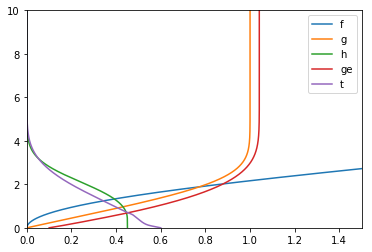

In [367]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
ax.plot(f, x,label='f')
ax.plot(g, x,label='g')
ax.plot(h, x,label='h')
ax.plot(ge, x,label='ge')
ax.plot(t, x,label='t')
ax.set_xbound(0,1.5)
ax.set_ybound(0,10)
ax.legend()


In [368]:
t

array([6.00000006e-01, 5.99948634e-01, 5.99897271e-01, ...,
       1.04146632e-13, 1.04079265e-13, 1.04011940e-13])